In [1]:
import pandas as pd
from sklearn import svm
import numpy as np

import matplotlib.pyplot as plt
import waterfall_chart

from scipy.spatial import distance
import itertools

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


Wczytywanie danych...

In [2]:
data = pd.read_stata('data.dta')

import pandas as pd
from sklearn import svm
import numpy as np

import matplotlib.pyplot as plt
import waterfall_chart

In [3]:
prepared_columns = ['S1','ppincimp', 'partyid7', 'ppwork', 'Q6A']
data_in = data[prepared_columns]

## Tworzenie słownika 
W związku z dużą liczbą kategorii w niektorych zmiennych utworzony został słownik z kategorami i odpowiadającymi im nazwami.

In [4]:
categories_dict = {}
for col in data_in.columns:
    categories_dict[col] = dict(enumerate(data_in.loc[:, col].cat.categories))

categories_dict

{'S1': {0: 'Yes, I am Married', 1: 'No, I am not Married'},
 'ppincimp': {0: 'Less than $5,000',
  1: '$5,000 to $7,499',
  2: '$7,500 to $9,999',
  3: '$10,000 to $12,499',
  4: '$12,500 to $14,999',
  5: '$15,000 to $19,999',
  6: '$20,000 to $24,999',
  7: '$25,000 to $29,999',
  8: '$30,000 to $34,999',
  9: '$35,000 to $39,999',
  10: '$40,000 to $49,999',
  11: '$50,000 to $59,999',
  12: '$60,000 to $74,999',
  13: '$75,000 to $84,999',
  14: '$85,000 to $99,999',
  15: '$100,000 to $124,999',
  16: '$125,000 to $149,999',
  17: '$150,000 to $174,999',
  18: '$175,000 to $199,999',
  19: '$200,000 to $249,999',
  20: '$250,000 or more'},
 'partyid7': {0: 'Strong Republican',
  1: 'Not Strong Republican',
  2: 'Leans Republican',
  3: 'Undecided/Independent/Other',
  4: 'Leans Democrat',
  5: 'Not Strong Democrat',
  6: 'Strong Democrat'},
 'ppwork': {0: 'Working - as a paid employee',
  1: 'Working - self-employed',
  2: 'Not working - on temporary layoff from a job',
  3: 'Not 

In [5]:
data_in = data_in.dropna()
data_in.shape

(2856, 5)

## Transformacja zmiennych

In [6]:
y = data_in['S1'].cat.codes
X = data_in.iloc[:, 1:].apply(lambda x: x.cat.codes, axis=0)

## Utworzenie modelu

In [7]:
X.values

array([[17,  1,  6,  1],
       [19,  4,  0,  1],
       [18,  6,  0,  1],
       ...,
       [16,  5,  0,  1],
       [12,  4,  0,  1],
       [10,  4,  0,  1]], dtype=int8)

In [8]:
svm_model = svm.SVC(gamma=0.01, probability=True)
svm_model.fit(X.values, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Zostały utworzone trzy funkcje w tym jedna główna (<u>ceteris_paribus_plot</u>). 

Funkcja ceteris_paribus_plot przyjmuje następujące argumenty:
1. model - model, który zostanie wyjaśniony
1. row - którą obserwację będziemy uznawać za "bazową"
1. test_x - dane do modelu
1. random - zmienna określająca czy wybór obserwacji "bazowej" ma nastąpić w sposób losowy
1. col - kolumna do wyjaśnienia
1. categories_dict - słownik z kategoriami w zmiennych

In [2]:
def ceteris_paribus_plot(model, row: int, test_x: pd.DataFrame, random: bool, col: str, categories_dict: dict):
    if random:
        selected_observation = test_x.iloc[np.random.randint(1, len(test_x)), :]
    else:
        selected_observation = test_x.iloc[row, :]
        
    possible_values = sorted(test_x[col].unique())
    probabilities = create_probabilities(model, selected_observation, col, possible_values)
    
    create_plot(possible_values, probabilities, col)
    print(categories_dict[col])
    
    
def create_probabilities(model, test_x, col, possible_values):
    probas = []
    for i in possible_values:
        test_x[col] = i
        probas.append(model.predict_proba([test_x.values])[0][0])
    
    return probas


def create_plot(possible_values, probabilities, col):
    plt.plot(possible_values, probabilities, marker='o', linestyle='--', color='b')
    plt.title(f'Ceteris Paribus plot for {col}')
    plt.ylabel("Probability")
    plt.xlabel(f'{col}')
    plt.show()
    
    
def pd_plot(model, test_x, col):
    values_range = list(np.sort(test_x[col].unique()))
    prob_dict = {}
    for value in values_range:
        temp = test_x.copy()
        temp[col] = value
        pred = temp.apply(lambda row: model.predict_proba([row.values])[0][0], axis=1)
        prob_dict[value] = np.mean(pred)
        
    create_pd_plot(prob_dict.keys(), prob_dict.values(), col)

def create_pd_plot(possible_values, probabilities, col):
    plt.plot(possible_values, probabilities, marker='o', linestyle='--', color='b')
    plt.title(f'pd_plot for {col}')
    plt.ylabel("Probability")
    plt.xlabel(f'{col}')
    plt.show()
    

def m_plot(model, test_x, col):
    tt = test_x.copy()
    values_range = list(np.sort(test_x[col].unique()))
    tt['pred'] = tt.apply(lambda row: model.predict_proba([row.values])[0][0], axis=1)
    prob_dict = {}
    for value in values_range:
        temp = tt[tt[col] == value]
        prob_dict[value] = np.mean(temp.pred)
        
    create_m_plot(prob_dict.keys(), prob_dict.values(), col)

    
def create_m_plot(possible_values, probabilities, col):
    plt.plot(possible_values, probabilities, marker='o', linestyle='--', color='b')
    plt.title(f'M_plot for {col}')
    plt.ylabel("Probability")
    plt.xlabel(f'{col}')
    plt.show()

Przeanalizowano wpływ zmiennej związanej z dochodem w gospodarstwie. Jak widać im więcej dochodu w gospodastwie tym większe prawdopodobieństwo, że osoba jest w związku małżeńskim.

Wariancja zmienne sugeruje, że zmienna ta jest istotna w modelu.

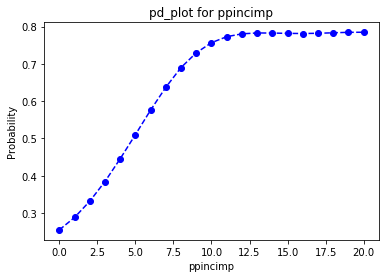

In [10]:
pd_plot(svm_model, X, 'ppincimp')

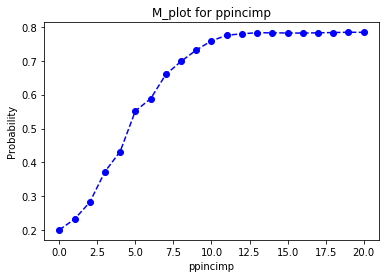

In [11]:
m_plot(svm_model, X, 'ppincimp')

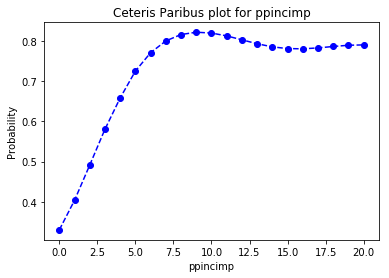

{0: 'Less than $5,000', 1: '$5,000 to $7,499', 2: '$7,500 to $9,999', 3: '$10,000 to $12,499', 4: '$12,500 to $14,999', 5: '$15,000 to $19,999', 6: '$20,000 to $24,999', 7: '$25,000 to $29,999', 8: '$30,000 to $34,999', 9: '$35,000 to $39,999', 10: '$40,000 to $49,999', 11: '$50,000 to $59,999', 12: '$60,000 to $74,999', 13: '$75,000 to $84,999', 14: '$85,000 to $99,999', 15: '$100,000 to $124,999', 16: '$125,000 to $149,999', 17: '$150,000 to $174,999', 18: '$175,000 to $199,999', 19: '$200,000 to $249,999', 20: '$250,000 or more'}


In [12]:
ceteris_paribus_plot(svm_model, 100, X, True, 'ppincimp', categories_dict)

Druga zmienna oznacza preferencje polityczne. Zmienna tak - jak wynika z wykresu - prawdopodobnie nie ogrywa znaczącej roli w modelu.

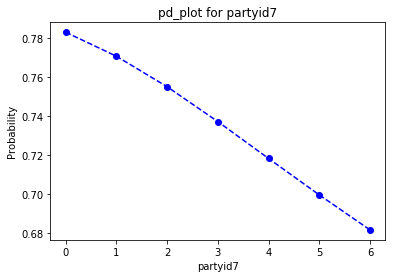

In [13]:
pd_plot(svm_model, X, 'partyid7')

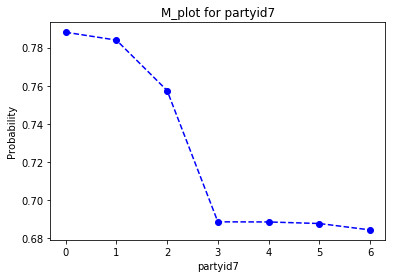

In [14]:
m_plot(svm_model, X, 'partyid7')

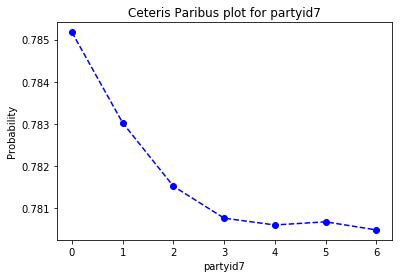

{0: 'Strong Republican', 1: 'Not Strong Republican', 2: 'Leans Republican', 3: 'Undecided/Independent/Other', 4: 'Leans Democrat', 5: 'Not Strong Democrat', 6: 'Strong Democrat'}


In [15]:
ceteris_paribus_plot(svm_model, 100, X, True, "partyid7", categories_dict)

Wykresy oparte na metodzie Ceteris Paribus oraz M_plot nie różnią się w wielki sposób, choć wykazują pewne różnice. Marginal Plot biorący pod uwagę lokalne wartości oczekiwane predykcji, są w pewnych obszarach zgoła inne aniżeli Ceteris Paribus Plots czy PD plots. Również są mniej gładkie. Wynikać to może z obliczenia lokalnych, a nie globalnych prawdopodobieństw i rozbicia naszej populacji na mniejsze podpopulacje podobne do siebie w pewnym względzie (w pewnej zmiennej).

Teraz zajmiemy się kolejnym sposobem interpretacji modelu.

In [16]:
def cond_expect(model, df, observation: dict):
    prediction_exp = {}
    result = {}
    pred = model.predict_proba(df.values)
    pred = [x[1] for x in pred]
    result['all'] = np.mean(pred)
    temp = df.copy()
    
    for k, v in observation.items():    
        temp[k] = v
        pred = model.predict_proba(temp.values)
        pred = [x[1] for x in pred]
        prediction_exp[k] = np.mean(pred)
        print(np.mean(pred))
        
    for k, v in prediction_exp.items():
        result[k] = v - result['all']
    
    return result

In [17]:
observation1 = {'ppincimp': 12, 'partyid7': 6, 'ppwork': 4, 'Q6A': 1}
observation2 = {'partyid7': 6, 'ppincimp': 12, 'Q6A': 1, 'ppwork': 4}

In [18]:
first = cond_expect(svm_model, X, observation1)
second = cond_expect(svm_model, X, observation2)

0.21961224180560696
0.23671967438681218
0.20740387260405896
0.20720519222453607
0.3182903971846597
0.23671967438681218
0.23693448035455408
0.20720519222453607


In [19]:
first

{'all': 0.2732420910594037,
 'ppincimp': -0.05362984925379677,
 'partyid7': -0.03652241667259154,
 'ppwork': -0.06583821845534477,
 'Q6A': -0.06603689883486766}

In [20]:
second

{'all': 0.2732420910594037,
 'partyid7': 0.045048306125255955,
 'ppincimp': -0.03652241667259154,
 'Q6A': -0.03630761070484964,
 'ppwork': -0.06603689883486766}

Z wyników wynika, że występuje interakcja między zmiennymi ppincimp oraz partyid7. W przypadku warunkowania w pierwszym kroku po 'ppincimp' zmienna 'partyid7' wpływa negatywnie na 'niebycie' w małżeństwie (0 - Yes, I am married; 1 - No, I am not). Jeżeli natomiast zmienimy kolejność warunkowania, zmienna 'partyid7' będzie wpływała poztywnie. Oznacza to, że kolejność warunkowania istotnie wpływa na wyniki metody Break Down. W przypadku pozostałych zmiennych nie widać dużej zmiany, chociaż aby jednoznacznie udzielić odpowiedzi, powinniśmy powtórzyć operację na wszystkich permutacjach zmiennych. Widać jednak, że kończowy rezultat istotnie różni się w obu przypadkach. Wyraźniej pokazują to poniższe wykresy.

<module 'matplotlib.pyplot' from 'C:\\Users\\LipaM\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

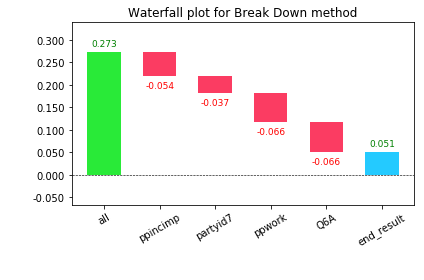

In [21]:
waterfall_chart.plot(list(first.keys()), list(first.values()), formatting='{:.3f}',
                    net_label='end_result', Title='Waterfall plot for Break Down method')

<module 'matplotlib.pyplot' from 'C:\\Users\\LipaM\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

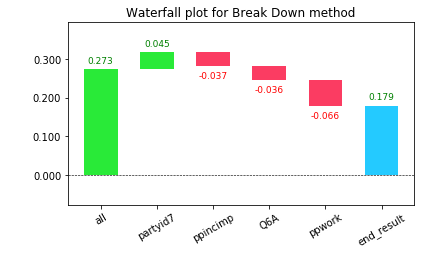

In [22]:
waterfall_chart.plot(list(second.keys()), list(second.values()), formatting='{:.3f}',
                    net_label='end_result', Title='Waterfall plot for Break Down method')

In [23]:
def cartesian_lime(model, df: pd.DataFrame, observation: list, similarity_perc):
    df['distance'] = df.apply(lambda x: distance.euclidean(x, observation), axis=1)
    
    n = int(np.floor(similarity_perc*len(df)))
    data = (df.sort_values('distance').drop_duplicates()).iloc[:n, :-1]
    
    vals = {}
    for i in range(len(data.columns)):
        vals[data.columns[i]] = list(data.iloc[:, i].unique())
        
    cart_df = pd.DataFrame(list(itertools.product(*vals.values())), columns=vals.keys())
    
    cart_df['pred'] = cart_df.apply(lambda x: model.predict_proba([x.values]), axis=1)
    cart_df['pred'] = cart_df.pred.apply(lambda x: x[0][1])
    
    cart_df['distance'] = cart_df.apply(lambda x: distance.euclidean(x[0:4], observation), axis=1)
    
    WLS = LinearRegression()
    WLS.fit(cart_df.iloc[:, :4], cart_df.loc[:, 'pred'], sample_weight=cart_df.loc[:, 'distance'])
    
    print(f'Interception: {WLS.intercept_}')
    for i in range(len(WLS.coef_)):
        print(f'{cart_df.columns[i]}: {WLS.coef_[i]}')
    return WLS

In [24]:
observation = [12, 6, 4, 1]
mm = cartesian_lime(svm_model, X, observation, 0.1)

Interception: 0.29267731229487626
ppincimp: -0.0062265424443805
partyid7: 0.014731992026363295
ppwork: -0.01019606489822909
Q6A: -0.001195082656474081


In [25]:
first

{'all': 0.2732420910594037,
 'ppincimp': -0.05362984925379677,
 'partyid7': -0.03652241667259154,
 'ppwork': -0.06583821845534477,
 'Q6A': -0.06603689883486766}

Teraz możemy porównać metodę LIME z kartezjańską perturbacją oraz metodę Break Dow. Znak we wpływie poszczególnych zmiennych na predykcję różni się tylko w przypadku zmiennej partyid7, chociaż jak pokazuje przykład z zeszłej pracy domowej inna permutacja kolumn wywołała dodatni wpływ tej zmiennej na predykcję w modelu. Jednak same wartości bezwzględne różnią sie znacząco. Nie do końca wiadomo czy jest to spowodowane metodą LIME czy dość niestandardową metodą perturbacji danych polegającą na wzięcie iloczynu kartezjańskiego obserwacji najbardziej podobnych do badanej obserwacji. Aby uzyskać wiarygodniejsze wyniki wypadałoby porównać wynik kartezjańskiego LIME z bardziej standardową wersją perturbacji.

PRACA DOMOWA 5

Dodatkowy model do pracy domowej

In [26]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.01)
xgb_model.fit(X.iloc[:, :-1].values, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [27]:
from sklearn.metrics import accuracy_score
from collections import defaultdict

In [28]:
print(f'Accuracy for xgboost: {accuracy_score(xgb_model.predict(X.iloc[:, :-1].values), y)}')

Accuracy for xgboost: 0.7706582633053222


C:\Users\LipaM\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [29]:
print(f'Accuracy for svm: {accuracy_score(svm_model.predict(X.iloc[:, :-1].values), y)}')

Accuracy for svm: 0.7573529411764706


Funkcje potrzebne w zadaniu domowym

In [30]:
def feature_importance(model, x, y, n_iter):
    accuracy = defaultdict(list)
    original_accuracy = accuracy_score(model.predict(x.values), y)
    for i in range(n_iter):
        for col in x.columns:
            temp_x = x.copy()
            temp_x[col] = np.random.permutation(temp_x[col].values)
            y_pred = model.predict(temp_x.values)
            feature_accuracy = accuracy_score(y, y_pred)
            accuracy[col].append(original_accuracy - feature_accuracy)
    for k in accuracy:
        accuracy[k] = np.mean(accuracy[k])
    return accuracy

In [31]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

importances = {}
importances['svm'] = feature_importance(svm_model, X.iloc[:, :-1], y, 100)
importances['xgb'] = feature_importance(xgb_model, X.iloc[:, :-1], y, 100)

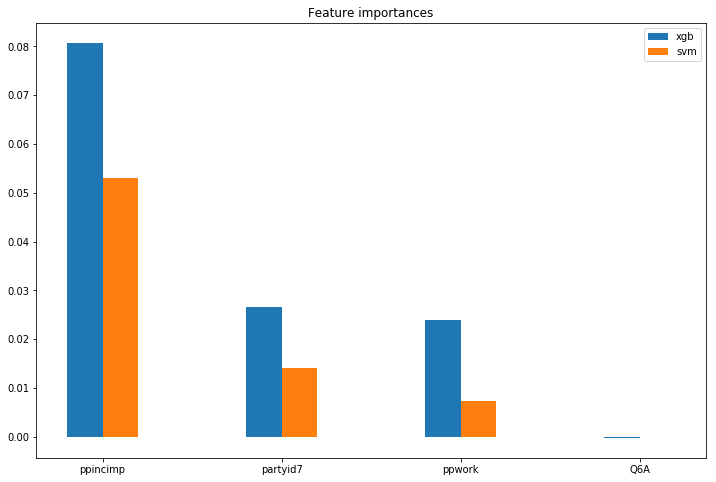

In [32]:
width = 0.2
plt.figure(figsize=(12,8))

plt.bar(np.arange(len(X.iloc[:, :-1].columns)), importances['xgb'].values(), width, label='xgb')
plt.bar(np.arange(len(X.iloc[:, :-1].columns)) + width, importances['svm'].values(), width, label='svm')

plt.xticks(np.array(range(len(importances['xgb']))) + width - 1/10, importances['xgb'].keys())
plt.title('Feature importances')
plt.legend()
plt.show()

Teraz skorzystam ze zrobionej podczas wcześniejszych prac domowych funkcji pd_plot. Pozwolę sobie porównać dwie zmienne, gdyż 'ppincimp' różni się najwięcej nominalnie, natomiast 'ppwork' procentowo. Warto spojrzeć na oba przypadki.

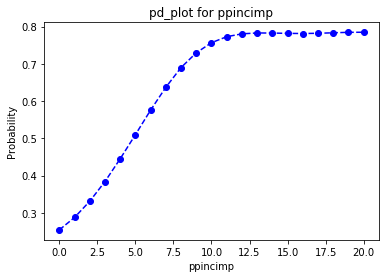

In [33]:
pd_plot(svm_model, X.iloc[:, :-1], 'ppincimp')

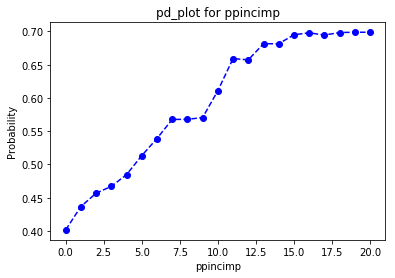

In [34]:
pd_plot(xgb_model, X.iloc[:, :-1], 'ppincimp')

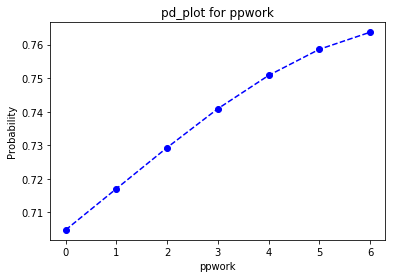

In [35]:
pd_plot(svm_model, X.iloc[:, :-1], 'ppwork')

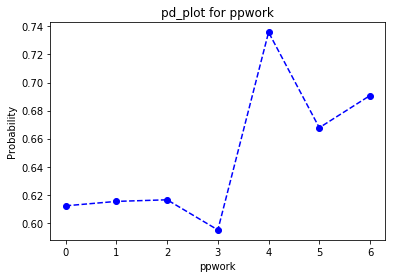

In [36]:
pd_plot(xgb_model, X.iloc[:, :-1], 'ppwork')

W pierwszym przypadku zmienna zachowuje się bardzo podobnie dla obu modeli. Większą wariancję prawdopodobieństwa ma model związany z xgboostem i ma "łamaną strukturę" ze względu na to, że jest to algorytm oparty na drzewach. W drugiej zmiennej mamy ciekawszą sytuację, gdyż tutaj zmienna w zależności od modelu przyjmuje zupełnie inne prawdopodobieństwa. Ogromna różnica między wyglądem jak i rozpiętością wartości prawdopodobieństwa przyjmowanych w obu modelach może wynikać z faktu, ze 'ppwork' dla modelu svm jest nieistotny i wpływ jest bliski 0, przez co rozróżnienie między poszczególnymi wartościami w tym modelu są znikome. Co ciekawe, pd_plot dla zmiennej ppwork w przypadku modelu xgboost mówi bardzo wiele i mówi bardzo intuicyjne rzeczy, gdyż największa zmiana jest między osobami, które

## Praca Domowa 6

Jako wyjaśniany model wezmę model oparty na Support Vector Machine

In [45]:
from statsmodels.nonparametric import smoothers_lowess
model_pd6 = svm_model

In [57]:
y_pd6 = y
X_pd6 = X.iloc[:, :-1]


In [41]:



plt.scatter(y_pred, res, label)
plt.plot(x_smooth,y_smooth, 'black', label = 'GEM curve')
plt.plot(predictions, zeros, 'r:', label = 'y = 0')
plt.title('Predictions vs Residuals ('+str(model_name)+')')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.legend()
plt.show()

,ppincimp,partyid7,ppwork,Q6A,distance
1,17,1,6,1,7.348469
2,19,4,0,1,8.306624
4,18,6,0,1,7.211103
5,13,6,4,1,1.000000
6,11,5,4,1,1.414214


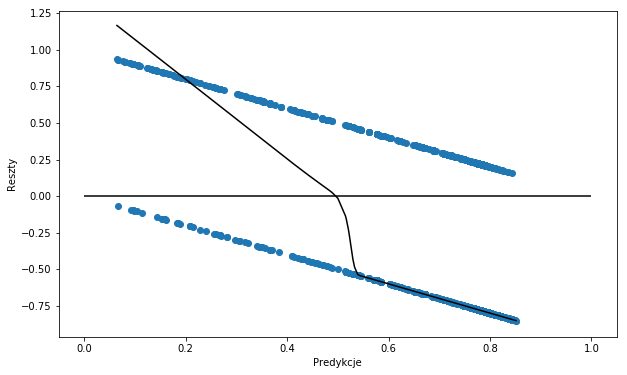

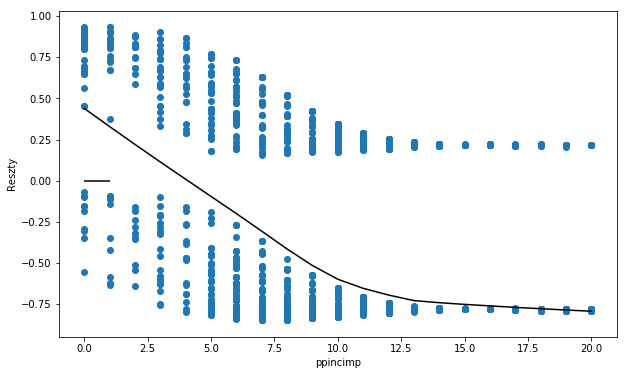

In [105]:
y_pred = X_pd6.apply(lambda x: model_pd6.predict_proba([x.values])[0][0], axis=1)
res = y_pd6 - y_pred

lowess = smoothers_lowess.lowess(res.values, y_pred.values, frac=0.95)
lowess_x = [i[0] for i in lowess]
lowess_y = [i[1] for i in lowess]

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, res)
plt.plot(lowess_x, lowess_y, 'black')
plt.hlines(0, 0, 1)
plt.xlabel('Predykcje')
plt.ylabel('Reszty')
plt.show()

selected_variable = X.loc[:, 'ppincimp']
lowess_var = smoothers_lowess.lowess(res.values, selected_variable.values, frac=0.9)
lowess_x_var = [i[0] for i in lowess_var]
lowess_y_var = [i[1] for i in lowess_var]
plt.figure(figsize=(10, 6))
plt.scatter(selected_variable, res)
plt.plot(lowess_x_var, lowess_y_var, 'black')
plt.hlines(0, 0, 1)
plt.xlabel('ppincimp')
plt.ylabel('Reszty')
plt.show()

In [89]:
def cook_distance(model, index, X, y, full_prediction):
    X = X.drop(index)
    y = y.drop(index)
    
    temp_model = svm.SVC(gamma=0.01, probability=True)
    temp_model.fit(X.values, y)
    
    y_pred = X.apply(lambda x: temp_model.predict_proba([x.values])[0][0], axis=1)
    return np.sqrt(np.mean(pow(full_prediction - y_pred,2)))

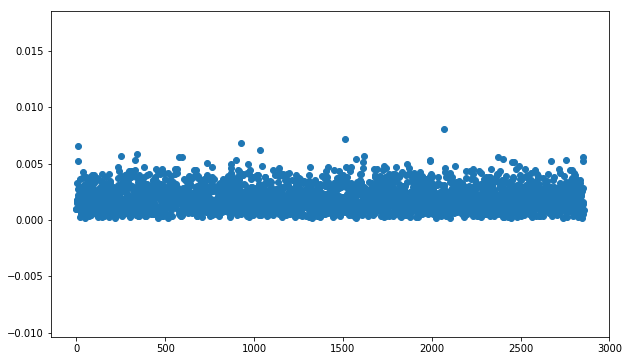

In [97]:
full_pred = X_pd6.apply(lambda x: model_pd6.predict_proba([x.values])[0][0], axis=1)
cook_dists = []
for i in X_pd6.index.values:
    cook_dists.append(cook_distance(model_pd6, i, X_pd6, y_pd6, full_pred))
    
plt.figure(figsize=(10,6))
plt.scatter(range(len(X_pd6)), cook_dists)
plt.show()

Odległość Cooka wykazuje co prawda kilka wartości nieznazcnie odstających od reszty obserwacji, natomiast sama wariancja i średnia odległość wskazują na dość stabilną strukturę modelu

# PRACA DOMOWA 8

In [2]:
import pandas as pd
import numpy as np

from sklearn import ensemble
from sklearn import metrics

import matplotlib.pyplot as plt

C:\Users\LipaM\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
data = pd.read_csv('dataset.csv')
data_train = data.iloc[:-5, :]
data_test = data.iloc[-5:, :]
X_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]

X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

In [3]:
model0 = ensemble.AdaBoostRegressor(n_estimators=100, learning_rate=0.1)
model1 = ensemble.RandomForestRegressor(n_estimators=100, max_depth=5)

In [4]:
model0.fit(X_train.values, y_train.values)
model1.fit(X_train.values, y_train.values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [5]:
y_pred0 = model0.predict(X_test.values)
y_pred1 = model1.predict(X_test.values)

In [6]:
print(f'mean squared error for AdaBoost: {metrics.mean_squared_error(y_test, y_pred0)}')
print(f'mean squared error for RandomForest: {metrics.mean_squared_error(y_test, y_pred1)}')

mean squared error for AdaBoost: 560.3824799999995
mean squared error for RandomForest: 946.9642773500112


Wybieramy AdaBoost jako elastic surrogate model

In [13]:
def pd_plot(model, test_x, col):
    values_range = list(np.sort(test_x[col].unique()))
    prob_dict = {}
    for value in values_range:
        temp = test_x.copy()
        temp[col] = value
        pred = temp.apply(lambda row: model.predict([row.values])[0], axis=1)
        prob_dict[value] = np.mean(pred)
        
    create_pd_plot(prob_dict.keys(), prob_dict.values(), col)

def create_pd_plot(possible_values, probabilities, col):
    plt.plot(possible_values, probabilities, marker='o', linestyle='--', color='b')
    plt.title(f'pd_plot for {col}')
    plt.ylabel("Target variable")
    plt.xlabel(f'{col}')
    plt.show()

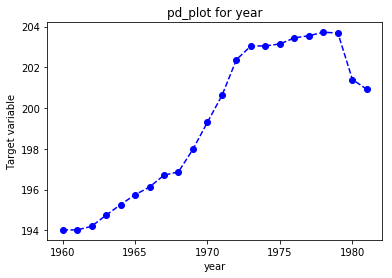

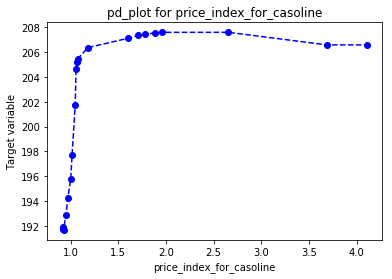

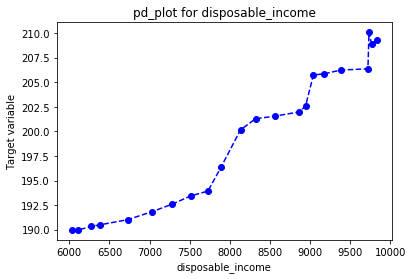

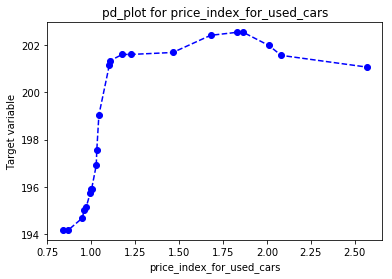

In [14]:
for col in X_test.columns:
    pd_plot(model0, X_train, col)

Tworzenie nowych zmiennych

In [20]:
data['price_gasoline_add'] = data.loc[:, 'price_index_for_casoline'].apply(lambda x: 0 if x <= 1.1 else 1)
data['disposable_income_add'] = data.loc[:, 'disposable_income'].apply(lambda x: 0 if x <= 7750 else (1 if x < 9000 else (2 if x < 9750 else 3)))
data['price_cars_add'] = data.loc[:, 'price_index_for_used_cars'].apply(lambda x: 0 if x <= 1.1 else 1)

In [43]:
X_train_new = data.iloc[:-5, :].drop('gasoline_consumption', axis=1)
y_train_new = data.iloc[:-5, 4]

X_test_new = data.iloc[-5:, :].drop('gasoline_consumption', axis=1)
y_test_new = data.iloc[-5:, 4]

In [48]:
basic_model = sm.OLS(y_train, X_train).fit()
base_pred = basic_model.predict(X_test)

basic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     gasoline_consumption   R-squared:                       1.000
Model:                              OLS   Adj. R-squared:                  0.999
Method:                   Least Squares   F-statistic:                     9039.
Date:                  Thu, 23 May 2019   Prob (F-statistic):           1.87e-29
Time:                          22:04:25   Log-Likelihood:                -64.419
No. Observations:                    22   AIC:                             136.8
Df Residuals:                        18   BIC:                             141.2
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
year                         -0.0537      0.004    -12.204      0.000      -0.063      -0.044
price_index_for_casoline    -21.6244      4.021     -5.377      0.000     -30.073     -13.176
disposable_income             0.0388      0.002     23.901      0.000       0.035       0.042
price_index_for_used_cars    16.6672      9.296      1.793      0.090      -2.864      36.198
==============================================================================
Omnibus:                        2.413   Durbin-Watson:                   0.526
Prob(Omnibus):                  0.299   Jarque-Bera (JB):                1.992
Skew:                          -0.699   Prob(JB):                        0.369
Kurtosis:                       2.532   Cond. No.                     7.91e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
glass_model = sm.OLS(y_train_new, X_train_new).fit()
glass_pred = glass_model.predict(X_test_new)

glass_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     gasoline_consumption   R-squared:                       1.000
Model:                              OLS   Adj. R-squared:                  1.000
Method:                   Least Squares   F-statistic:                 1.342e+04
Date:                  Thu, 23 May 2019   Prob (F-statistic):           7.69e-26
Time:                          22:04:34   Log-Likelihood:                -49.689
No. Observations:                    22   AIC:                             115.4
Df Residuals:                        14   BIC:                             124.1
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
year                         -0.0277      0.005     -5.144      0.000      -0.039      -0.016
price_index_for_casoline    -28.9494      3.272     -8.848      0.000     -35.967     -21.932
disposable_income             0.0307      0.002     18.744      0.000       0.027       0.034
price_index_for_used_cars    26.6519      7.315      3.644      0.003      10.964      42.340
year0                        11.6535      3.099      3.760      0.002       5.006      18.301
price_gasoline_add           -9.7024      3.457     -2.807      0.014     -17.116      -2.288
disposable_income_add         0.5081      2.073      0.245      0.810      -3.938       4.954
price_cars_add                7.6489      2.977      2.570      0.022       1.265      14.033
==============================================================================
Omnibus:                        1.963   Durbin-Watson:                   1.621
Prob(Omnibus):                  0.375   Jarque-Bera (JB):                1.320
Skew:                          -0.350   Prob(JB):                        0.517
Kurtosis:                       2.026   Cond. No.                     1.15e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
print(f'mean squared error for AdaBoost: {metrics.mean_squared_error(y_test, y_pred0)}')
print(f'mean squared error for RandomForest: {metrics.mean_squared_error(y_test, y_pred1)}')
print(f'mean squared error for linear model: {metrics.mean_squared_error(y_test, base_pred)}')
print(f'mean squared error for glass model: {metrics.mean_squared_error(y_test, glass_pred)}')


mean squared error for AdaBoost: 560.3824799999995
mean squared error for RandomForest: 946.9642773500112
mean squared error for linear model: 73410.58250209127
mean squared error for glass model: 40121.00906146898


In [51]:
glass_pred

22    243.551053
23    262.959126
24    -16.412360
25    -11.915003
26     13.968765
dtype: float64

In [52]:
X_test_new

,year,price_index_for_casoline,disposable_income,price_index_for_used_cars,year0,price_gasoline_add,disposable_income_add,price_cars_add
22,1982,3.894,9725,2.964,3,1,2,1
23,1983,3.764,9930,3.297,3,1,3,1
24,1984,3.707,421,3.757,3,1,0,1
25,1985,3.738,563,3.797,3,1,0,1
26,1986,2.921,780,3.632,3,1,0,1


Niestety, jak widać z powyższych wyników, modele liniowe nie poradziły sobie kompletnie z tym problemem. Być może ma to związek z tym, że mamy do czynienia z szeregiem czasowym oraz z faktu, że obserwacji nie jest zbyt dużo. Najwiekszy wpływ na takie złe wyniki miały trzy ostatnie obserwacje, które są ewidentnymi outlierami i w związku z tym model liniowy niestety nie był w stanie dostosować do tego swoich predykcji, które okazały się zupełnie niesłuszne (w dodatku bezsensowne, bo na minusie). Nie wiadomo skąd takie dziwne obserwacje w zbiorze testowym, natomiast wyniki przez to nie są do końca adekwatne i wartościowe z perspektywy ogólniejszych wniosków na temat tej metody. 

Porównując jednak model bazowy (regresja liniowa) i model oparty na większej liczbie zmienych widać znaczącą poprawę, co może świadczyć o ogólnej wartości tej metody, szczególnie w przypadku restrykcji co do modelu. Błąd średniokwadratowy zmalał o prawie 50%, można więc to uznać za mały sukces. 

Podsumowując, wypadałoby powtórzyć ten eksperyment dla innych danych lub sprawdzić na większym szeregu czasowym (więcej obserwacji) czy nie znajdziemy takiego rodzaju zbiorów danych, z którymi metoda SAFE sobie nie radzi.

In [3]:
X = pd.read_table('rotatingHyperplane.txt', sep=' ', header=-1)
y = pd.read_table('rotatingHyperplaneLabels.txt', sep=' ', header=-1)

C:\Users\LipaM\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
C:\Users\LipaM\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


In [4]:
X_0 = X.iloc[:16000, :]
X_1 = X.iloc[-20000:, :]
X_test = X.iloc[16000:20000, :]

y_0 = y.iloc[:16000, 0]
y_1 = y.iloc[-20000:, 0]
y_test = y.iloc[16000:20000, :]

Na początek utworzymy model oparty na regresji logistycznej

In [26]:
model0 = LogisticRegression()
model0.fit(X_0.values, y_0.values)

model1 = LogisticRegression()
model1.fit(X_1.values, y_1.values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Pierwszym krokiem będzie analiza rezduów. Spróbujemy wyznaczyć rezydua modelu oraz sprawdzić czy zaszły zmiany między dwoma podpróbami. Jako miarę zmienności zastosujemy przecięcie histogramu

In [28]:
y_0_pred = model0.predict_proba(X_0)[:, 1]
y_1_pred = model1.predict_proba(X_1)[:, 1]

In [33]:
res0 = y_0 - y_0_pred
res1 = y_1 - y_1_pred

In [40]:
def intersection_distance(x, y, bins):
    print(f'stats for first data -> mean: {np.mean(x)}, std: {np.std(x)}')
    print(f'stats for second data -> mean: {np.mean(y)}, std: {np.std(y)}')
        
    plt.figure(figsize=(10, 6))
    h0 = plt.hist(x, bins=bins, normed=True)[0]
    h1 = plt.hist(y, bins=bins, alpha=0.8, normed=True)[0]
    plt.show()
    
    intersection = 0
    s = 0
    for i in range(len(h0)):
        s = s + h0[i]
        intersection = intersection + min(h0[i], h1[i])
        
    print(f'Intersection -> {intersection/s}')

stats for first data -> mean: -0.0009942181200630988, std: 0.300479759473539
stats for second data -> mean: -0.0002654866068802967, std: 0.31603799691204004


C:\Users\LipaM\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


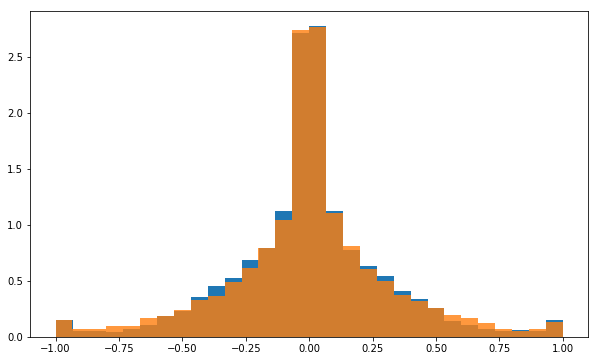

Intersection -> 0.9670270645995199


In [41]:
intersection_distance(res0, res1, bins=30)

Z powyższego histogramu oraz wyniku znajdującego sie pod nim wynika, że nie ma różnicy między rezyduami z obu modeli utworzonych na różnych danych. Wynik intersection jest bliski 1.

Teraz zajmiemy się intersection distance dla zmiennych w modelu

In [42]:
test0 = X.iloc[:20000, :]
test1 = X.iloc[-20000:, :]

In [44]:
def intersection_distance(x: pd.Series, y: pd.Series, bins):
    print(f'stats for first data -> mean: {x.mean()}, std: {x.std()}')
    print(f'stats for second data -> mean: {y.mean()}, std: {y.std()}')
    
    plt.figure(figsize=(10, 6))
    h0 = plt.hist(x, bins=bins)[0]
    h1 = plt.hist(y, bins=bins, alpha=0.8)[0]
    plt.show()
    
    intersection = 0
    for i in range(len(h0)):
        intersection = intersection + min(h0[0], h1[i])
        
    print(f'Intersection -> {intersection/len(x)}')

stats for first data -> mean: 0.4979843972500047, std: 0.2889845025519043
stats for second data -> mean: 0.5015595482000014, std: 0.28988060477356603


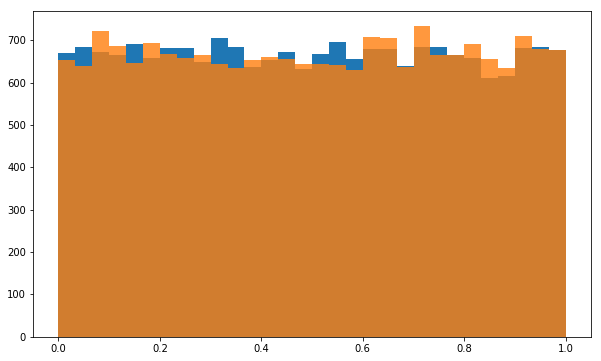

Intersection -> 0.9847


In [45]:
intersection_distance(test0.iloc[:, 0], test1.iloc[:, 0], 30)

stats for first data -> mean: 0.4979843972500047, std: 0.2889845025519043
stats for second data -> mean: 0.5015595482000014, std: 0.28988060477356603


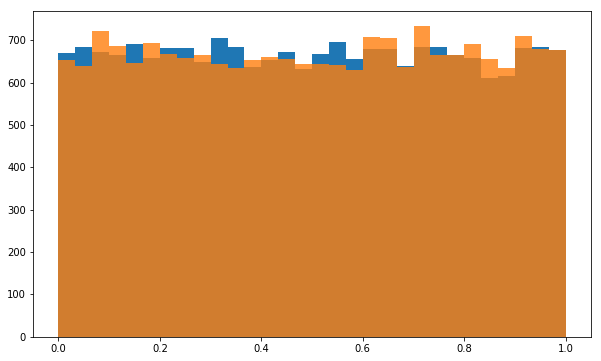

Intersection -> 0.9847
stats for first data -> mean: 0.4978988986000014, std: 0.2889443504349831
stats for second data -> mean: 0.5009178844499967, std: 0.2916141931591127


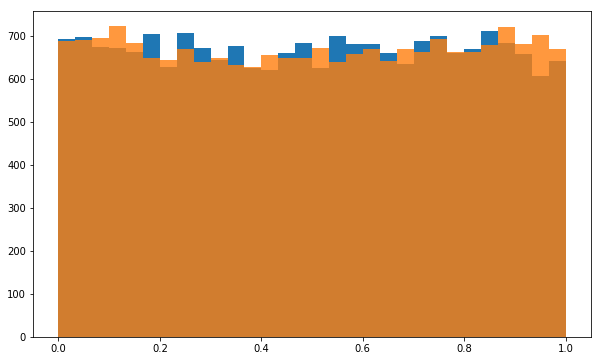

Intersection -> 0.9965
stats for first data -> mean: 0.5015309676000025, std: 0.28809391718923205
stats for second data -> mean: 0.49996783655000393, std: 0.2889493515628491


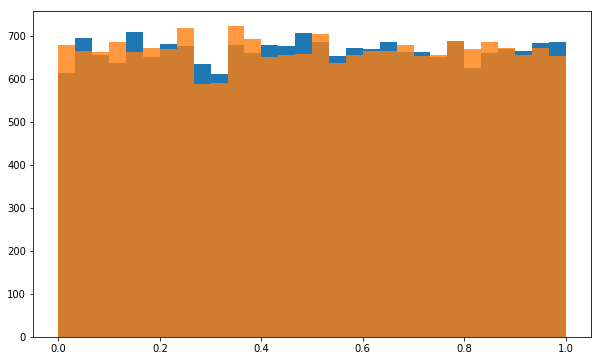

Intersection -> 0.9172
stats for first data -> mean: 0.495105755899999, std: 0.28946874466100525
stats for second data -> mean: 0.5043650574999996, std: 0.28966561046653216


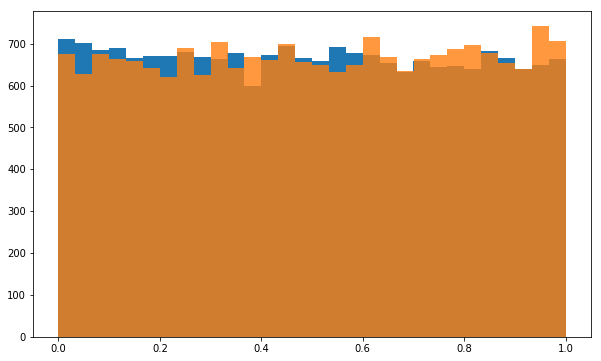

Intersection -> 0.99835
stats for first data -> mean: 0.4997920643000034, std: 0.28928996552928893
stats for second data -> mean: 0.5045500626999998, std: 0.2893427128175147


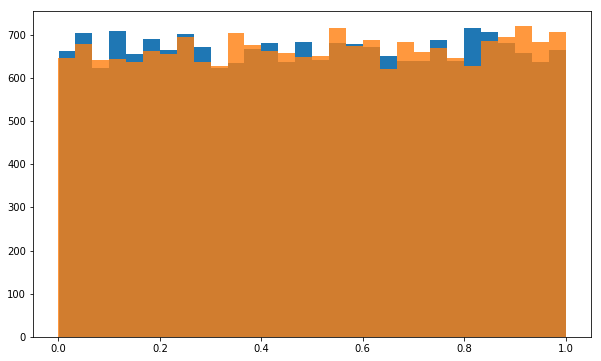

Intersection -> 0.9804
stats for first data -> mean: 0.5006245011000008, std: 0.28986363776876956
stats for second data -> mean: 0.49593337674999677, std: 0.2896618195380262


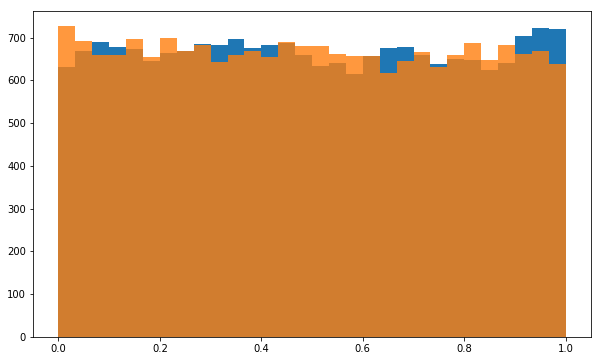

Intersection -> 0.9458
stats for first data -> mean: 0.49950853760000247, std: 0.2897948234167081
stats for second data -> mean: 0.49874675645000127, std: 0.28740567377648024


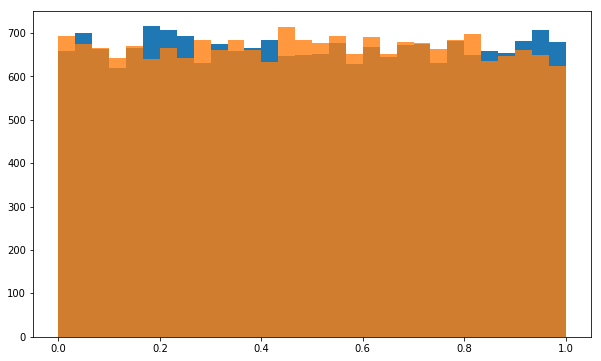

Intersection -> 0.97885
stats for first data -> mean: 0.49842531815, std: 0.2872836900953224
stats for second data -> mean: 0.5020776001000057, std: 0.2868932024094987


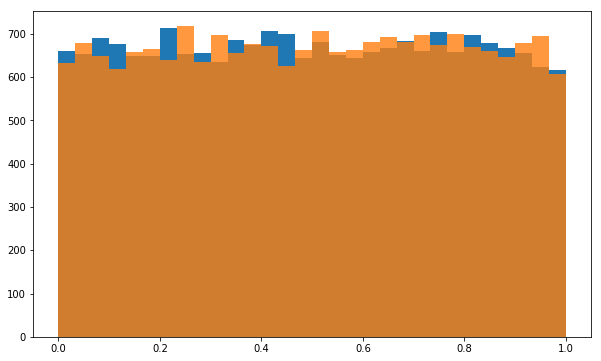

Intersection -> 0.9784
stats for first data -> mean: 0.5011174750500014, std: 0.2887195556901178
stats for second data -> mean: 0.49615159185000085, std: 0.29014111936510445


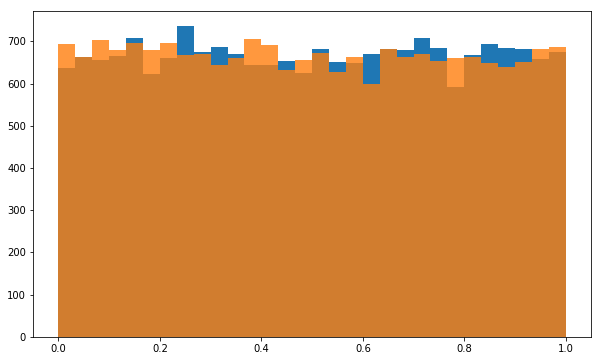

Intersection -> 0.95295
stats for first data -> mean: 0.5008945549500018, std: 0.28901545807599277
stats for second data -> mean: 0.5000873981999999, std: 0.28949998802089283


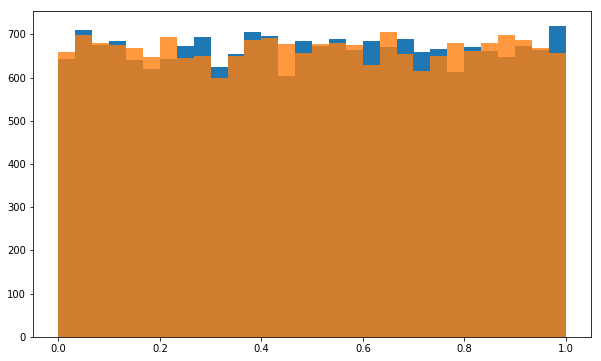

Intersection -> 0.95875


In [46]:
for i in range(len(test0.columns)):
    intersection_distance(test0.iloc[:, i], test1.iloc[:, i], 30)

Jako ostatni krok przedstawimy różnice między krzywymi PD plot dla konkretnych zmiennych w modelu.

Na powyższych histogramach oraz wynikach intersection widać, że nie występuje zjawisko concept driftu. Wszystkie wartości intersection są bliskie zeru, najmniejsza wartość to 0.9172.

Partial Dependency plots dla dwóch modeli

In [48]:
cols = X_0.columns

In [49]:
cols

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [66]:
def compare_pd_plots(model0, model1, x0, x1, col):
    values_range = list(np.sort(x0[col].unique()))
    prob_dict0 = {}
    prob_dict1 = {}
    for value in values_range:
        temp0 = x0.copy()
        temp1 = x1.copy()
        temp0[col] = value
        temp1[col] = value
        pred0 = model0.predict_proba(temp0)[:, 1]
        pred1 = model1.predict_proba(temp1)[:, 1]
        prob_dict0[value] = np.mean(pred0)
        prob_dict1[value] = np.mean(pred1)
        
    intersection = 0
    s = 0
    for v in values_range:
        intersection = intersection + abs(prob_dict0[v] - prob_dict1[v])
        s = s + prob_dict0[v]
    create_double_pd_plot(prob_dict0.keys(), prob_dict1.keys(), prob_dict0.values(), prob_dict1.values(), col, round(intersection/s, 3))

def create_double_pd_plot(possible_values0, possible_values1, probabilities0, probabilities1, col, intersection):
    plt.plot(possible_values0, probabilities0)
    plt.plot(possible_values1, probabilities1)
    plt.title(f'pd_plot for {col} -> area: {intersection}')
    plt.ylabel("Probability")
    plt.xlabel(f'{col}')
    plt.show()

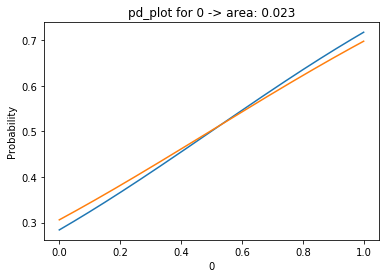

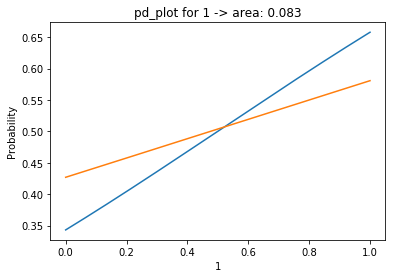

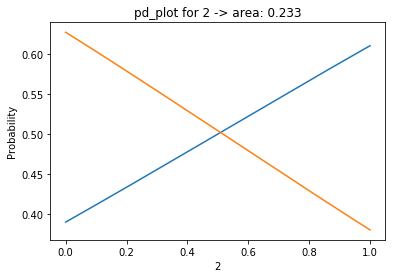

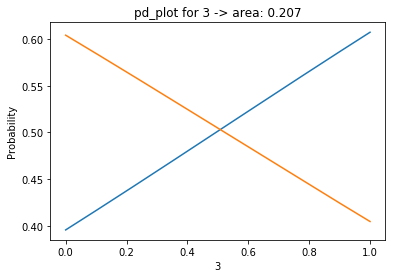

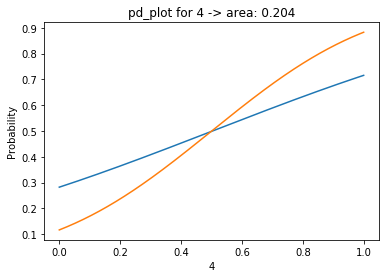

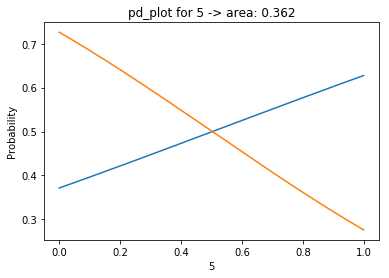

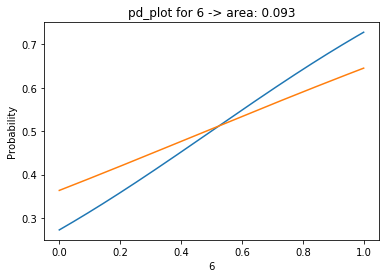

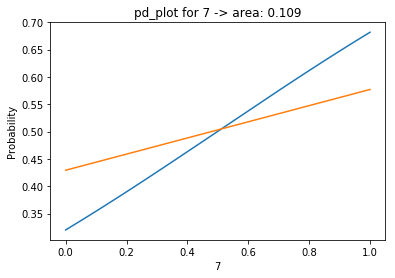

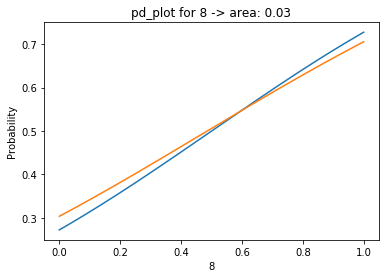

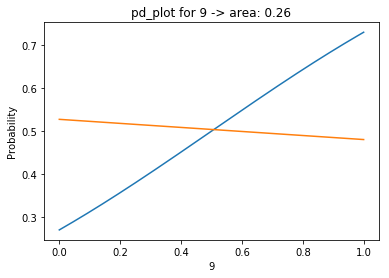

In [67]:
for i in range(10):
    compare_pd_plots(model0, model1, X_0, X_1, i)

Większość zmiennych wykazuje zmianę w wyglądacie krzywej PD. Największa zmiana jest obserwowana dla zmiennej 5, gdzie jeden model ma rosnące prawdopodobieństwo wraz z rozsnącą zmienną, natomiast w drugim modelu ta zależność jest odwrotna. Dla zmiennych 0 oraz 8 nie odnotowano znaczących zmian w wyglądzie krzywych, pole między wykresami jest mniejsze niż 0.05. 